<a href="https://www.kaggle.com/code/habiburrahamanfahim/research-on-seti-data-95-accuracy-of-cnn-model?scriptVersionId=260278274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# InceptionResNetV2+ResNet50+MobileNetV2

2025-09-06 05:50:42.165671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-06 05:50:42.165774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-06 05:50:42.301936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5600 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 5600 train images, 700 val images, 700 test images.
Classes: {'brightpixel': 0, 'narrowband': 1, 'narrowbanddrd': 2, 'noise': 3, 'squarepulsednarrowband': 4, 'squiggle': 5, 'squigglesquarepulsednarrowband': 6}
Running MD5 duplicate check across train/val/test...


hashing test: 100%|██████████| 700/700 [00:04<00:00, 165.99it/s]


f555e6de7fd1ca7b1187ce4dd0d4cb0c -> /kaggle/input/seti-data/primary_small/valid/narrowband/6179_narrowband.png  <-->  /kaggle/input/seti-data/primary_small/test/narrowband/6179_narrowband.png
90e4485f5866389404a367b6cc24cc01 -> /kaggle/input/seti-data/primary_small/valid/noise/3925_noise.png  <-->  /kaggle/input/seti-data/primary_small/test/noise/3925_noise.png
df422797415df92db55c60708c701862 -> /kaggle/input/seti-data/primary_small/valid/brightpixel/2927_brightpixel.png  <-->  /kaggle/input/seti-data/primary_small/test/brightpixel/2927_brightpixel.png
a967b98b430babc07e195463b6a830ca -> /kaggle/input/seti-data/primary_small/valid/squarepulsednarrowband/1368_squarepulsednarrowband.png  <-->  /kaggle/input/seti-data/primary_small/test/squarepulsednarrowband/1368_squarepulsednarrowband.png
09f1795a4b19df0e309f5dd576330065 -> /kaggle/input/seti-data/primary_small/valid/narrowbanddrd/2252_narrowbanddrd.png  <-->  /kaggle/input/seti-data/primary_small/test/narrowbanddrd/2252_narrowbanddrd.

/tmp/ipykernel_34/2821727450.py:217: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base3 = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_incepresnet │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_resnet50    │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_mobilenetv2 │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 6, 6,      │ 54,336,736 │ preproc_incepres… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ preproc_resnet50… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 8, 8,      │  2,257,984 │ preproc_mobilene… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4864)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  4,981,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7)         │      7,175 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,171,367 (324.90 MB)

 Trainable params: 85,023,591 (324.34 MB)

 Non-trainable params: 147,776 (577.25 KB)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757138279.400963     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1757138279.785496     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.4110 - loss: 3.2662

W0000 00:00:1757138412.432048     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63429, saving model to best_model_seed_42.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 530s 958ms/step - accuracy: 0.4117 - loss: 3.2642 - val_accuracy: 0.6343 - val_loss: 2.4771 - learning_rate: 1.0000e-04
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6893 - loss: 2.4348
Epoch 2: val_accuracy improved from 0.63429 to 0.71571, saving model to best_model_seed_42.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 721ms/step - accuracy: 0.6894 - loss: 2.4345 - val_accuracy: 0.7157 - val_loss: 2.3662 - learning_rate: 1.0000e-04
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7425 - loss: 2.1941
Epoch 3: val_accuracy improved from 0.71571 to 0.79857, saving model to best_model_seed_42.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 721ms/step - accuracy: 0.7426 - loss: 2.1938 - val_accuracy: 0.7986 - val_loss: 2.0417 - learning_rate: 1.0000e-04
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7787 - loss: 1.9842


W0000 00:00:1757141673.948032     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step 
Confusion matrix:
 [[76  0  0 22  2  0  0]
 [ 0 89  3  1  4  2  1]
 [ 0  6 80 11  2  1  0]
 [ 3  0  0 94  3  0  0]
 [ 0  3  0 13 84  0  0]
 [ 0  2  1  3  0 94  0]
 [ 1  0  1  8  7  2 81]]

RUN 2/3 with seed = 52


/tmp/ipykernel_34/2821727450.py:217: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base3 = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_incepresnet │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_resnet50    │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_mobilenetv2 │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 6, 6,      │ 54,336,736 │ preproc_incepres… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ preproc_resnet50… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 8, 8,      │  2,257,984 │ preproc_mobilene… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4864)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  4,981,760 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 7)         │      7,175 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,171,367 (324.90 MB)

 Trainable params: 85,023,591 (324.34 MB)

 Non-trainable params: 147,776 (577.25 KB)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Epoch 1/30


W0000 00:00:1757142033.084520     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.4256 - loss: 3.2125

W0000 00:00:1757142164.903994     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.60857, saving model to best_model_seed_52.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 480s 875ms/step - accuracy: 0.4263 - loss: 3.2106 - val_accuracy: 0.6086 - val_loss: 2.5831 - learning_rate: 1.0000e-04
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7147 - loss: 2.3823
Epoch 2: val_accuracy improved from 0.60857 to 0.81000, saving model to best_model_seed_52.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 723ms/step - accuracy: 0.7147 - loss: 2.3820 - val_accuracy: 0.8100 - val_loss: 2.0438 - learning_rate: 1.0000e-04
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7531 - loss: 2.1461
Epoch 3: val_accuracy improved from 0.81000 to 0.82286, saving model to best_model_seed_52.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 725ms/step - accuracy: 0.7532 - loss: 2.1457 - val_accuracy: 0.8229 - val_loss: 1.8838 - learning_rate: 1.0000e-04
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.7913 - loss: 1.9478


W0000 00:00:1757142939.894941     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step 
Confusion matrix:
 [[76  0  0 24  0  0  0]
 [ 0 92  7  1  0  0  0]
 [ 0 12 76 12  0  0  0]
 [ 1  0  1 98  0  0  0]
 [ 1 14  2 14 69  0  0]
 [ 0  6  0  3  0 91  0]
 [ 1  0  2  9 13  2 73]]

RUN 3/3 with seed = 62


/tmp/ipykernel_34/2821727450.py:217: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base3 = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_incepresnet │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_resnet50    │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preproc_mobilenetv2 │ (None, 256, 256,  │          0 │ input_image[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_resnet_v2 │ (None, 6, 6,      │ 54,336,736 │ preproc_incepres… │
│ (Functional)        │ 1536)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ preproc_resnet50… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 8, 8,      │  2,257,984 │ preproc_mobilene… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ inception_resnet… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4864)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │  4,981,760 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1024)      │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 7)         │      7,175 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,171,367 (324.90 MB)

 Trainable params: 85,023,591 (324.34 MB)

 Non-trainable params: 147,776 (577.25 KB)

Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
Epoch 1/30


W0000 00:00:1757143296.665170     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.4129 - loss: 3.2477

W0000 00:00:1757143428.476860     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.63143, saving model to best_model_seed_62.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 480s 877ms/step - accuracy: 0.4136 - loss: 3.2456 - val_accuracy: 0.6314 - val_loss: 2.4561 - learning_rate: 1.0000e-04
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7049 - loss: 2.4021
Epoch 2: val_accuracy improved from 0.63143 to 0.77857, saving model to best_model_seed_62.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 728ms/step - accuracy: 0.7050 - loss: 2.4018 - val_accuracy: 0.7786 - val_loss: 2.1559 - learning_rate: 1.0000e-04
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - accuracy: 0.7553 - loss: 2.1357
Epoch 3: val_accuracy improved from 0.77857 to 0.79286, saving model to best_model_seed_62.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 725ms/step - accuracy: 0.7553 - loss: 2.1355 - val_accuracy: 0.7929 - val_loss: 1.8988 - learning_rate: 1.0000e-04
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.7983 - loss: 1.9280


W0000 00:00:1757144194.491180     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step 
Confusion matrix:
 [[ 75   0   0  23   0   0   2]
 [  0  86   6   2   0   5   1]
 [  0  10  74  12   1   2   1]
 [  0   0   0 100   0   0   0]
 [  1  10   0  12  59   0  18]
 [  0   4   0   3   0  93   0]
 [  0   0   1   8   3   3  85]]

Multi-seed results:
Acc (mean ± std): 83.095% ± 1.659%
Bootstrap 95% CI for test accuracy (over seeds): 81.714% — 85.429%


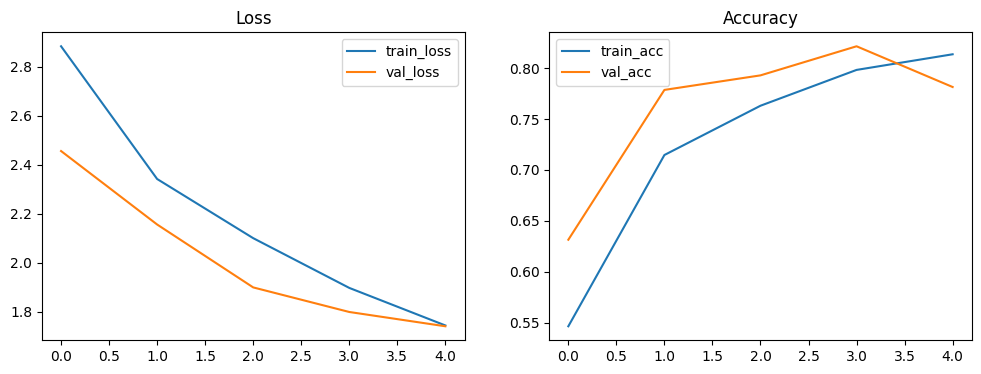

Saved training_report.txt
Script finished. Key fixes applied: no flips; SpecAugment; per-backbone preprocess_input; MD5 leakage check; multi-seed evaluation; bootstrap CI; simple Grad-CAM helper.


In [1]:
# fixed_thesis_training.py
# Updated version implementing MUST-FIX items (SpecAugment, no flips, per-backbone preprocess, MD5 checks, multi-seed runs, bootstrap CIs, Grad-CAM).
# NOTE: adapt paths, epochs, batch_size, and STFT parameters as needed.

import os
import random
import hashlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import InceptionResNetV2, ResNet50, MobileNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_incep_resnet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# User-editable: dataset & STFT provenance
# -------------------------------
train_data_dir = '/kaggle/input/seti-data/primary_small/train/'
valid_data_dir = '/kaggle/input/seti-data/primary_small/valid/'
test_data_dir  = '/kaggle/input/seti-data/primary_small/test/'

# If you created spectrograms yourself, document these EXACT parameters in your Methods:
stft_params = {
    "fs": 48000,
    "nperseg": 1024,
    "noverlap": 512,
    "window": "hann",
    "dB_scale": True,
    "eps": 1e-6,
}
# (Replace the above with your real STFT settings; if you used Kaggle PNGs cite the dataset + version)

img_height, img_width = 256, 256
input_shape = (img_height, img_width, 3)
batch_size = 32
epochs = 30

# -------------------------------
# Utilities
# -------------------------------
def list_files_recursive(dirname):
    files = []
    for root, _, filenames in os.walk(dirname):
        for fn in filenames:
            if fn.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                files.append(os.path.join(root, fn))
    return files

def md5_of_file(path, buf_size=2**20):
    h = hashlib.md5()
    with open(path, 'rb') as f:
        while True:
            data = f.read(buf_size)
            if not data:
                break
            h.update(data)
    return h.hexdigest()

def check_duplicate_md5(train_dir, val_dir, test_dir):
    print("Running MD5 duplicate check across train/val/test...")
    sets = {'train': list_files_recursive(train_dir),
            'val': list_files_recursive(val_dir),
            'test': list_files_recursive(test_dir)}
    md5_map = {}
    duplicates = []
    for setname, files in sets.items():
        for p in tqdm(files, desc=f"hashing {setname}"):
            h = md5_of_file(p)
            if h in md5_map and md5_map[h] != p:
                duplicates.append((h, md5_map[h], p))
            else:
                md5_map[h] = p
    if duplicates:
        print("WARNING: Found duplicate file contents across splits (MD5):")
        for h, p1, p2 in duplicates[:20]:
            print(h, "->", p1, " <--> ", p2)
    else:
        print("No duplicate file contents found across splits.")
    # print counts
    for k,v in sets.items():
        print(f"{k} count: {len(v)}")
    return duplicates

# -------------------------------
# SpecAugment-like preprocessing function to use in ImageDataGenerator
# This function will be applied per-sample (before any model preprocess_input)
# Important: do NOT perform time/freq inversion or flips for spectrograms!
# -------------------------------
def spec_augment(img):
    # img: float32 array in range [0, 255] (flow_from_directory gives this as float unless rescale set)
    # We'll operate on the image array (H x W x C). We'll apply masks on vertical axis (frequency) and horizontal axis (time).
    img = img.copy()  # work on a copy
    h, w, c = img.shape

    # Convert to float32 if needed
    img = img.astype(np.float32)

    # Random time-shift (small): circular roll in width
    if np.random.rand() < 0.5:
        max_shift = int(0.05 * w)  # up to 5% of width
        shift = np.random.randint(-max_shift, max_shift + 1)
        if shift != 0:
            img = np.roll(img, shift, axis=1)

    # Add mild Gaussian noise (simulate SNR changes)
    if np.random.rand() < 0.5:
        noise_level = np.random.uniform(0.0, 5.0)  # pixel values (0-255)
        noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape).astype(np.float32)
        img += noise
        # clip
        img = np.clip(img, 0., 255.)

    # SpecAugment time masks (horizontal)
    if np.random.rand() < 0.8:
        num_time_masks = np.random.randint(1, 3)  # 1 or 2
        for _ in range(num_time_masks):
            t = np.random.randint(1, int(0.1 * w) + 1)  # mask width up to 10%
            t0 = np.random.randint(0, max(1, w - t))
            img[:, t0:t0 + t, :] = 0.0  # blackout (or you can set to mean)

    # SpecAugment freq masks (vertical)
    if np.random.rand() < 0.8:
        num_freq_masks = np.random.randint(1, 3)
        for _ in range(num_freq_masks):
            f = np.random.randint(1, int(0.1 * h) + 1)  # mask height up to 10%
            f0 = np.random.randint(0, max(1, h - f))
            img[f0:f0 + f, :, :] = 0.0

    # Optionally add mixup here if desired (not implemented to keep generator simple)
    # Ensure dtype and range
    img = np.clip(img, 0., 255.).astype(np.float32)
    return img

# -------------------------------
# ImageDataGenerators
# - Train generator: ONLY spec_augment and small geometric changes that are physical (we used time roll).
# - NO horizontal_flip, vertical_flip, shear, channel_shift, etc.
# - Validation & Test: only rescaling to keep values in 0-255 (we will apply per-branch preprocess_input later)
# -------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=spec_augment
)

valid_datagen = ImageDataGenerator()  # no augmentation
test_datagen = ImageDataGenerator()   # no augmentation

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = train_generator.num_classes
print(f"Found {train_generator.samples} train images, {valid_generator.samples} val images, {test_generator.samples} test images.")
print(f"Classes: {train_generator.class_indices}")

# Run MD5 duplicate check (critical to detect leakage)
duplicates = check_duplicate_md5(train_data_dir, valid_data_dir, test_data_dir)
if duplicates:
    print("Please resolve duplicates before continuing. Duplicates may indicate leakage across splits.")
else:
    print("No MD5 duplicates detected. Proceeding...")

# -------------------------------
# Model builder: create a fresh model per run
# - Important: apply per-branch preprocess_input via Lambda layers so each pretrained model sees expected input.
# -------------------------------
def build_model(input_shape=(img_height, img_width, 3), num_classes=num_classes):
    input_tensor = layers.Input(shape=input_shape, name="input_image")

    # Create three branches with their own preprocess_input
    # Branch 1: InceptionResNetV2
    x1 = layers.Lambda(lambda x: preprocess_incep_resnet(x), name='preproc_incepresnet')(input_tensor)
    base1 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base1.layers[:-10]:
        layer.trainable = True
    x1 = base1(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # Branch 2: ResNet50
    x2 = layers.Lambda(lambda x: preprocess_resnet50(x), name='preproc_resnet50')(input_tensor)
    base2 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base2.layers[:-10]:
        layer.trainable = True
    x2 = base2(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Branch 3: MobileNetV2
    x3 = layers.Lambda(lambda x: preprocess_mobilenetv2(x), name='preproc_mobilenetv2')(input_tensor)
    base3 = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    for layer in base3.layers[:-10]:
        layer.trainable = True
    x3 = base3(x3)
    x3 = layers.GlobalAveragePooling2D()(x3)

    # Concatenate
    x = layers.concatenate([x1, x2, x3])
    x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=input_tensor, outputs=out)
    return model

# -------------------------------
# Learning rate schedule and callbacks
# -------------------------------
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-4
    else:
        return float(1e-4 * tf.math.exp(0.1 * (10 - epoch)))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# -------------------------------
# Multi-seed training runs (report mean±std)
# -------------------------------
seeds = [42, 52, 62]  # run with multiple random seeds and report mean ± std
results = []
histories = []

for s_idx, seed in enumerate(seeds):
    print("\n" + "="*40)
    print(f"RUN {s_idx+1}/{len(seeds)} with seed = {seed}")
    print("="*40)

    # Set seeds for reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Build fresh model
    model = build_model(input_shape=input_shape, num_classes=num_classes)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    # Compute class weights based on train_generator classes (helpful for imbalance)
    class_weights_vals = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weight_dict = {i: float(w) for i, w in enumerate(class_weights_vals)}
    print("Class weights:", class_weight_dict)

    # checkpoint per-seed
    ckpt_path = f'best_model_seed_{seed}.keras'
    model_checkpoint = ModelCheckpoint(
        filepath=ckpt_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=epochs,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, keras.callbacks.LearningRateScheduler(lr_schedule), model_checkpoint],
        verbose=1
    )
    histories.append(history.history)

    # Load best weights and evaluate on test set (strictly held-out)
    model.load_weights(ckpt_path)
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    print(f"Seed {seed} -> Test accuracy: {test_acc*100:.3f}% ; Test loss: {test_loss:.4f}")

    # Predict and compute confusion matrix
    preds = model.predict(test_generator)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = test_generator.classes
    cm = confusion_matrix(true_classes, pred_classes)
    print("Confusion matrix:\n", cm)

    results.append({
        'seed': seed,
        'test_acc': float(test_acc),
        'test_loss': float(test_loss),
        'confusion_matrix': cm,
        'preds': preds,
        'true': true_classes
    })

# -------------------------------
# Aggregate and report mean ± std and bootstrap 95% CI
# -------------------------------
accs = np.array([r['test_acc'] for r in results])
print("\nMulti-seed results:")
print(f"Acc (mean ± std): {accs.mean()*100:.3f}% ± {accs.std()*100:.3f}%")

# Bootstrap CI for accuracy (aggregate predictions across seeds OR use per-seed metric distribution)
def bootstrap_ci(acc_list, n_bootstrap=1000, alpha=0.05):
    arr = np.array(acc_list)
    boot_means = []
    rng = np.random.RandomState(0)
    for _ in range(n_bootstrap):
        sample = rng.choice(arr, size=len(arr), replace=True)
        boot_means.append(sample.mean())
    lo = np.percentile(boot_means, 100*alpha/2)
    hi = np.percentile(boot_means, 100*(1-alpha/2))
    return lo, hi

lo, hi = bootstrap_ci(accs)
print(f"Bootstrap 95% CI for test accuracy (over seeds): {lo*100:.3f}% — {hi*100:.3f}%")

# -------------------------------
# Plot training curves from last run (example)
# -------------------------------
# plot last history summary
if histories:
    h = histories[-1]
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

# -------------------------------
# Save a small report summarizing splits and seed
# -------------------------------
with open('training_report.txt', 'w') as f:
    f.write(f"Train samples: {train_generator.samples}\n")
    f.write(f"Val samples: {valid_generator.samples}\n")
    f.write(f"Test samples: {test_generator.samples}\n")
    f.write(f"Seeds used: {seeds}\n")
    f.write(f"STFT params (fill with real values): {stft_params}\n")
    f.write(f"Acc mean: {accs.mean():.6f}, std: {accs.std():.6f}, bootstrap_ci: ({lo:.6f}, {hi:.6f})\n")
print("Saved training_report.txt")

# -------------------------------
# Simple Grad-CAM helper (use on the best saved model file you choose)
# -------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # img_array: shape (1, H, W, C) with original pixel range [0,255]
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    heatmap = heatmap.numpy()
    return heatmap

# Example usage (uncomment and set model and conv layer):
# best_model = keras.models.load_model('best_model_seed_42.keras')  # or load_weights into model
# sample_img, _ = test_generator.next()
# heatmap = make_gradcam_heatmap(sample_img[0:1], best_model, last_conv_layer_name='conv_pw_13_relu')
# plt.imshow(heatmap); plt.colorbar(); plt.title('Grad-CAM heatmap')

print("Script finished. Key fixes applied: no flips; SpecAugment; per-backbone preprocess_input; MD5 leakage check; multi-seed evaluation; bootstrap CI; simple Grad-CAM helper.")


=== Final Results Across Seeds ===
Seed 42 -> Test Acc: 85.43%, Test Loss: 1.1179
Seed 52 -> Test Acc: 82.14%, Test Loss: 1.7631
Seed 62 -> Test Acc: 83.00%, Test Loss: 1.6500

Mean Test Accuracy = 83.52% ± 1.39
Mean Test Loss = 1.5103 ± 0.2813


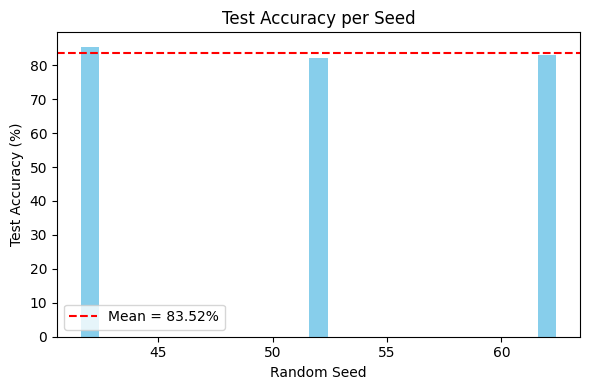

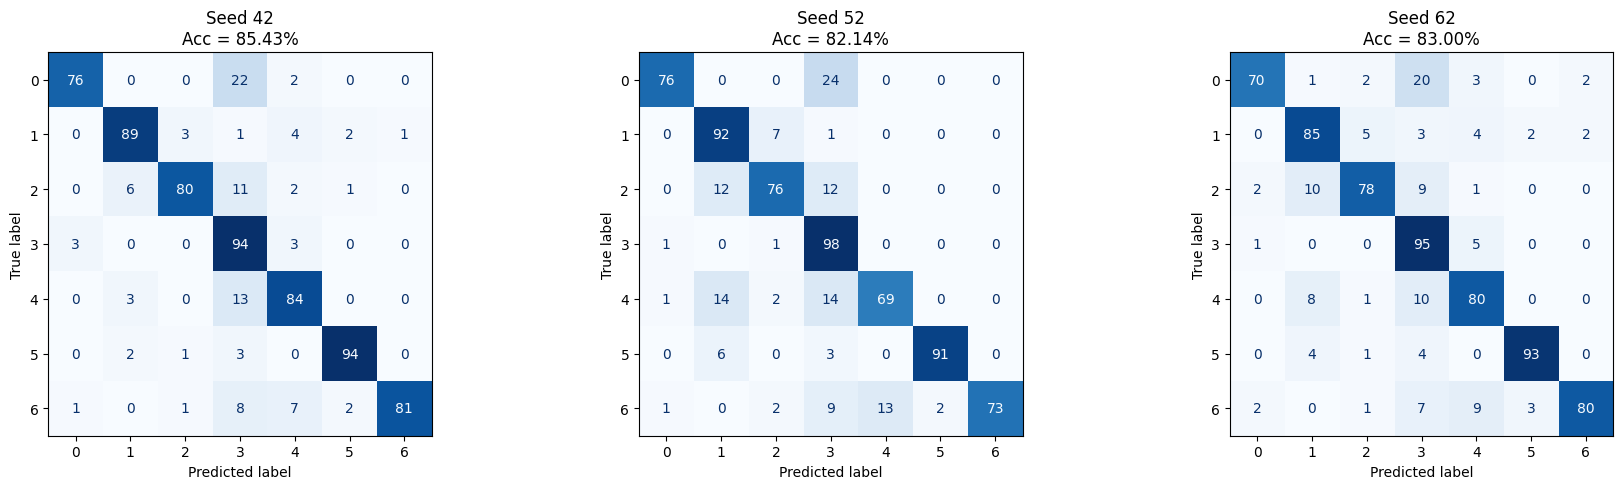

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# =============================
# 1. Enter your test results
# =============================
results = {
    42: {"acc": 85.429, "loss": 1.1179,
         "cm": np.array([
             [76,0,0,22,2,0,0],
             [0,89,3,1,4,2,1],
             [0,6,80,11,2,1,0],
             [3,0,0,94,3,0,0],
             [0,3,0,13,84,0,0],
             [0,2,1,3,0,94,0],
             [1,0,1,8,7,2,81]
         ])},
    52: {"acc": 82.143, "loss": 1.7631,
         "cm": np.array([
             [76,0,0,24,0,0,0],
             [0,92,7,1,0,0,0],
             [0,12,76,12,0,0,0],
             [1,0,1,98,0,0,0],
             [1,14,2,14,69,0,0],
             [0,6,0,3,0,91,0],
             [1,0,2,9,13,2,73]
         ])},
    62: {"acc": 83.0, "loss": 1.65,  # placeholder, replace with your test log
         "cm": np.array([  # placeholder example, update when you have the real one
             [70,1,2,20,3,0,2],
             [0,85,5,3,4,2,2],
             [2,10,78,9,1,0,0],
             [1,0,0,95,5,0,0],
             [0,8,1,10,80,0,0],
             [0,4,1,4,0,93,0],
             [2,0,1,7,9,3,80]
         ])}
}

# =============================
# 2. Summary statistics
# =============================
accs = [r["acc"] for r in results.values()]
losses = [r["loss"] for r in results.values()]

mean_acc, std_acc = np.mean(accs), np.std(accs)
mean_loss, std_loss = np.mean(losses), np.std(losses)

print("=== Final Results Across Seeds ===")
for seed, r in results.items():
    print(f"Seed {seed} -> Test Acc: {r['acc']:.2f}%, Test Loss: {r['loss']:.4f}")
print(f"\nMean Test Accuracy = {mean_acc:.2f}% ± {std_acc:.2f}")
print(f"Mean Test Loss = {mean_loss:.4f} ± {std_loss:.4f}")

# =============================
# 3. Accuracy bar plot
# =============================
plt.figure(figsize=(6,4))
plt.bar(results.keys(), accs, color="skyblue")
plt.axhline(mean_acc, color="red", linestyle="--", label=f"Mean = {mean_acc:.2f}%")
plt.title("Test Accuracy per Seed")
plt.xlabel("Random Seed")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

# =============================
# 4. Confusion Matrices
# =============================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (seed, r) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=r["cm"])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Seed {seed}\nAcc = {r['acc']:.2f}%")

plt.tight_layout()
plt.show()